## Import Libraries

In [52]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [53]:
final_data = pd.read_csv('final_data.csv')

In [54]:
final_data.shape

(10754, 22)

In [55]:
final_data.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [56]:
# uniqeness
final_data.drop_duplicates(inplace=True)
final_data[final_data.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [57]:
# Completeness
final_data.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [58]:
# Accurecy types
final_data.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [59]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
numeric_features = ['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'days_injured', 'games_injured', 'award', 'current_value', 'highest_value', 'position_encoded', 'winger']
categorical_features = ['team', 'name', 'position']

In [60]:
for i in categorical_features:
    print (final_data[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64
name
Paulinho              6
Vitinho               5
Guilherme             5
Fernando              4
João Pedro            4
                     ..
Everson               1
Matheus Mendes        1
Gabriel Delfim        1
Nathan Silva          1
Alexander Badolato    1
Name: count, Length: 10584, dtype: int64
position
Defender Centre-Back          1821
Attack Centre-Forward         1353
Goalkeeper                    1229
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     900
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     769
Attack-RightWinger             717
Att

In [61]:
final_data.shape

(10754, 22)

In [62]:
award_counts = final_data.groupby('name')['award'].sum().sort_values(ascending=False)

top_10_names = award_counts.head(10)

name_with_highest_award = top_10_names.idxmax()
highest_award_count = top_10_names.max()

fig = px.bar(top_10_names, x=top_10_names.values, y=top_10_names.index, orientation='h', 
             labels={'x': 'Award Count', 'index': 'Name'}, title='Top 10 Names Based on Award Counts')

fig.add_shape(type="line", x0=0, x1=highest_award_count, y0=name_with_highest_award, 
              y1=name_with_highest_award, line=dict(color="Red", width=3), xref='x', yref='y')

fig.add_annotation(x=highest_award_count, y=name_with_highest_award, 
                   text=f'Highest Award Count: {highest_award_count}', 
                   showarrow=True, arrowhead=2, ax=20, ay=-30)

fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()

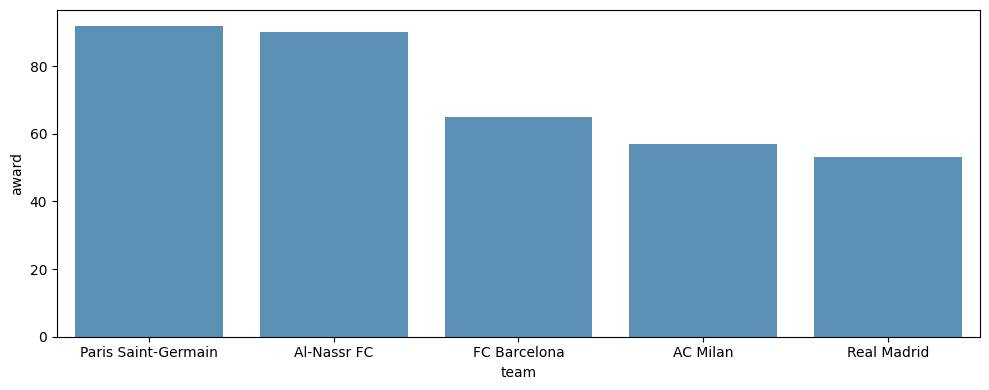

In [63]:
top_teams = final_data.nlargest(5, 'award')

plt.figure(figsize=(10, 4))
sns.barplot(data=top_teams, x='team', y='award', alpha=0.8)
plt.tight_layout()
plt.show()

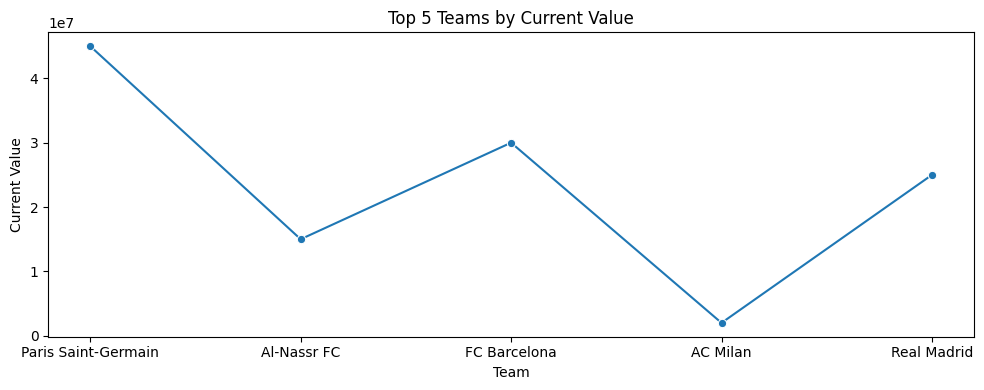

In [64]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=top_teams, x='team', y='current_value', marker='o')
plt.title('Top 5 Teams by Current Value')
plt.xlabel('Team')
plt.ylabel('Current Value')
plt.tight_layout()
plt.show()

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [65]:
final_data.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [66]:
categorical_features

['team', 'name', 'position']

In [67]:
# one hot coding
df = pd.get_dummies(final_data, columns=categorical_features)

In [68]:
final_data.shape

(10754, 22)

In [69]:
final_data.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [70]:
p35 = final_data['current_value'].quantile(0.35)
p75 = final_data['current_value'].quantile(0.75)

def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

final_data['price_category'] = final_data['current_value'].apply(categorize_price)

final_data.drop('current_value', axis=1, inplace=True)

print(final_data['price_category'].value_counts())

price_category
Good_Price     4310
Cheap_Price    3754
High_Price     2690
Name: count, dtype: int64


In [71]:
p35, p75

(450000.0, 3000000.0)

In [72]:
encoder = LabelEncoder()
final_data['price_category'] = encoder.fit_transform(final_data['price_category'])  

#### 3. Feature selection

In [73]:
# sns.heatmap(df.corr(), annot=True);

In [74]:
correlation = final_data.corr(numeric_only=True)
print(correlation['price_category'].sort_values(ascending=False))

price_category         1.000000
appearance             0.546979
minutes played         0.519476
highest_value          0.488265
award                  0.242359
games_injured          0.229243
days_injured           0.197838
assists                0.163772
position_encoded       0.135433
goals                  0.120438
winger                 0.025773
height                 0.024424
age                    0.023627
yellow cards           0.012427
second yellow cards   -0.002912
red cards             -0.006292
clean sheets          -0.031388
goals conceded        -0.128555
Name: price_category, dtype: float64


In [75]:
threshold = 0.2  

selected_features = correlation[abs(correlation['price_category']) > \
threshold]['price_category'].index
selected_features

Index(['appearance', 'minutes played', 'games_injured', 'award',
       'highest_value', 'price_category'],
      dtype='object')

In [76]:
final_data.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,highest_value,position_encoded,winger,price_category
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,70000000,1,0,2
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,22000000,1,0,1


In [77]:
final_data = final_data[selected_features]
final_data.head()

,appearance,minutes played,games_injured,award,highest_value,price_category
0,104,9390,5,13,70000000,2
1,15,1304,58,1,22000000,1
2,4,292,84,4,6000000,1
3,82,6408,22,9,50000000,2
4,63,5031,51,21,80000000,2


#### 4. Prepare train and test data

In [78]:
# Prepare data
X = final_data.drop(['price_category'], axis=1)


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [79]:
X.shape

(10754, 5)

## Buliding the Model

In [80]:
wcss = []
for i in range(1, 20):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS


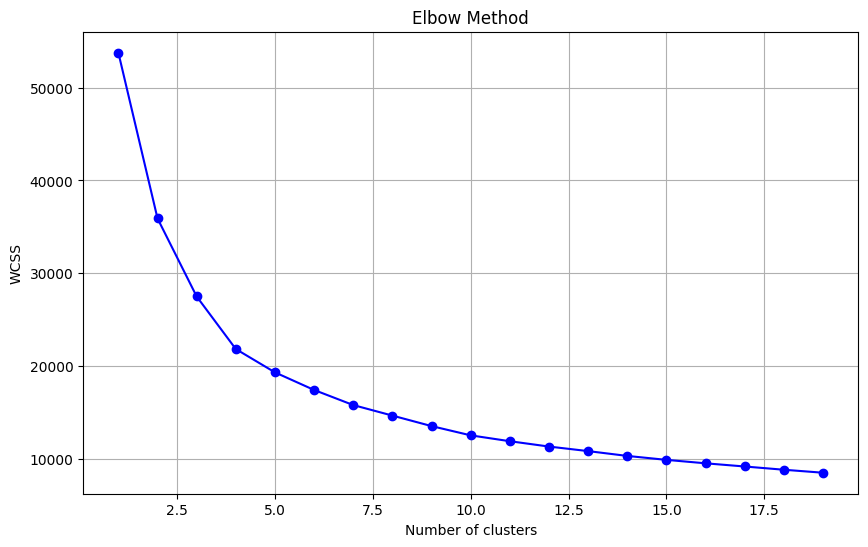

In [81]:
# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [82]:
# Optional: Apply k-Means using the optimal number of clusters
optimal_clusters = 8 # This might change based on your actual elbow curve analysis
model = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

## Train and Test the Model

In [83]:
# Fit the model on the training data
y_pred = model.fit_predict(X_scaled)

## Evaluating the Model 

In [84]:
X.head(2)

,appearance,minutes played,games_injured,award,highest_value
0,104,9390,5,13,70000000
1,15,1304,58,1,22000000


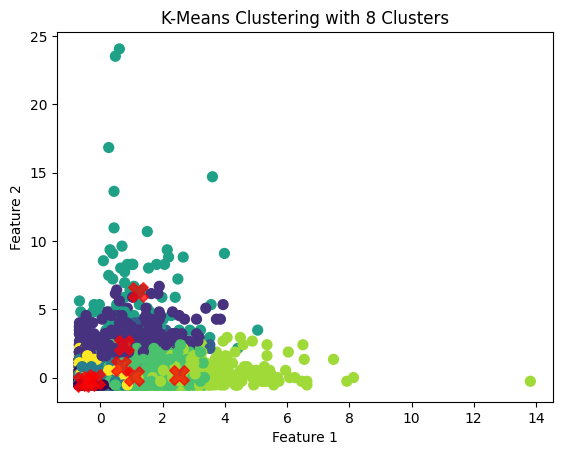

In [85]:
# Plotting the clusters with optimal number
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=y_pred, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [86]:
X['kmeans'] = y_pred

In [87]:
X['kmeans'].value_counts()

kmeans
0    3820
3    2514
7    1945
5     984
6     635
1     420
2     351
4      85
Name: count, dtype: int64

In [88]:
X[X['kmeans']==0]

,appearance,minutes played,games_injured,award,highest_value,kmeans
84,17,1530,10,0,400000,0
103,12,124,0,0,12000000,0
120,11,651,0,5,15000000,0
148,21,1259,6,1,12000000,0
164,23,2070,0,0,200000,0
...,...,...,...,...,...,...
10749,16,1023,0,0,75000,0
10750,26,1449,18,0,300000,0
10751,20,960,0,0,50000,0
10752,17,865,0,0,50000,0


<Axes: xlabel='highest_value', ylabel='minutes played'>

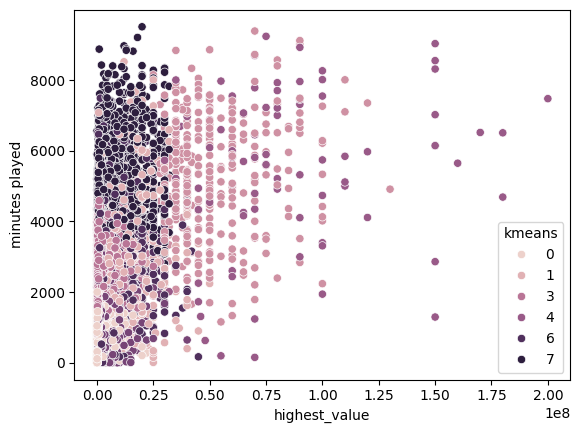

In [89]:
sns.scatterplot(data = X , x = 'highest_value', y = 'minutes played', hue = 'kmeans')